# MCMC Inference 

## Import package and our code

In [1]:
import jax
import jax.numpy as jnp
from jax import jit,random
import matplotlib.pylab as plt

import sys
sys.path.append('code')

from Kernel import *
from GaussianProcess import GaussianProcess
%matplotlib inline

## Setup init

In [2]:
Num_params = 2
RBF =  Kernel(rbf_kernel,Num_params, jnp.ones(Num_params), [(1e-5, 1e5)] * Num_params, kernel_name='dp')

n_samples = 50
rng_key = random.PRNGKey(42)
def f(X):
    return jnp.sin(3 * X[:, 0] + 10 * X[:, 1])*X[:, 0]

Num_points = 50
X = jnp.array([jnp.linspace(0, 1, Num_points),jnp.linspace(-1, 0, Num_points)]).T
y = f(X) +jax.random.uniform(jax.random.PRNGKey(0), (Num_points, ))*0.0001 # add some random noisy 

# Initialize the kernel with initial parameters
kernel = RBF

# Initialize the Gaussian Process model
gp = GaussianProcess(kernel=kernel, sigma_n=1e-5, optimizer='adam')

# Fit the Gaussian Process model to the data
gp.fit(X, y)

## Perform MCMC inference to estimate kernel parameters

In [3]:
initial_theta = kernel.param_values
n_samples = 1000
burn_in = 200
thinning = 5
#print("log_posterior function:", log_posterior)
theta_samples = gp.mcmc_inference(initial_theta, n_samples=n_samples, burn_in=burn_in, thinning=thinning)

# Print the mean and standard deviation of the sampled kernel parameters
print("Mean of length_scale samples:", jnp.mean(theta_samples[:, 0]))
print("Std of length_scale samples:", jnp.std(theta_samples[:, 0]))
print("Mean of signal_variance samples:", jnp.mean(theta_samples[:, 1]))
print("Std of signal_variance samples:", jnp.std(theta_samples[:, 1]))

# Set kernel parameters to their posterior mean
kernel.param_values = jnp.mean(theta_samples, axis=0)

Mean of length_scale samples: 0.32119093340392296
Std of length_scale samples: 0.1360706025698067
Mean of signal_variance samples: 0.39406597990411757
Std of signal_variance samples: 0.28603263637281695


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4.940075534770954e-05


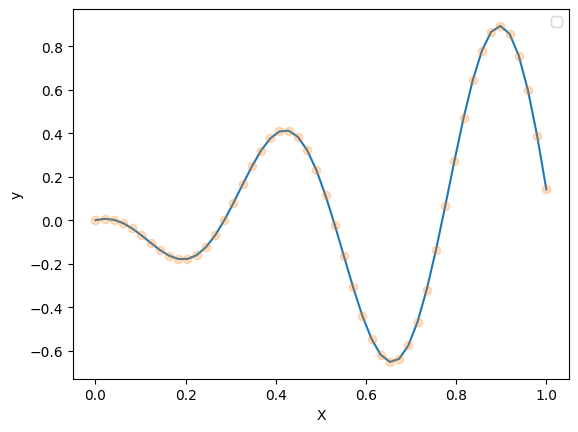

In [4]:
# Make predictions
X_test = jnp.array([jnp.linspace(0, 1, 50),jnp.linspace(-1, 0, 50)]).T
#y_test = (f(X_test)/mean>.65).astype(int)
y_test = f(X_test)
y_pred = gp.predict(X_test)
#y_prob = gp.predict_proba(X_test)
print(jnp.sum(jnp.abs(y_test - y_pred.flatten()))/y_pred.size)

# Plot the results
import matplotlib.pyplot as plt


plt.plot(X_test[:,0],y_test,)
#plt.plot(X_test[:,0],y_prob,alpha =0.25)
plt.plot(X_test[:,0],y_pred,"o",alpha =0.25)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()